In [1]:
import torch
from torch.utils.data import Dataset
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import h5py

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
#if not os.path.exists("traindata.pkl"):
#    !wget -O traindata.pkl https://tu-dortmund.sciebo.de/s/kpCMGPutwk6vKOP/download

In [3]:
train_data1 = pd.read_pickle("data/train_data_50627_mixed.pkl")
train_data1 = train_data1.drop(train_data1.index[3516:3591])     # Removing the undesired data samples
                               
train_data2 = pd.read_pickle("data/train_data_50631_mixed.pkl")

train_data3 = pd.read_pickle("data/train_data_2023_11-08.pkl")

#train_data2 = pd.read_pickle("data/train_data_[49473, 49477, 49487, 49489].pkl")
#train_data3 = pd.read_pickle("data/train_data_20231108.pkl")

train_data = pd.concat([train_data1, train_data2, train_data3], ignore_index=True)
# train_data = pd.concat([train_data1, train_data2, train_data3], ignore_index=True)

del train_data1, train_data2, train_data3

In [4]:
#def convert_to_float(arr):
#    return np.array(arr, dtype=np.float32)

#train_data['train_X'] = train_data['train_X'].apply(convert_to_float)
#train_data['train_Y'] = train_data['train_Y'].apply(convert_to_float)

In [5]:
train_df, val_df = train_test_split(train_data, test_size = 0.2)

train_X, train_Y = train_df['train_X'], train_df['train_Y']
val_X, val_Y = val_df['train_X'], val_df['train_Y']

Train set size : 5865 	 Validation set size : 1467
(155, 272) (155, 272)


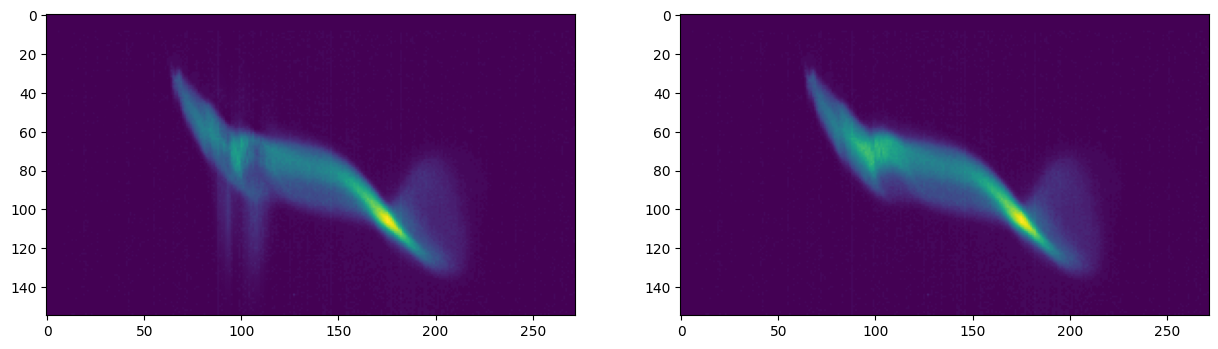

In [7]:
print(f"Train set size : {train_X.shape[-1]} \t Validation set size : {val_X.shape[-1]}")
idx = 16
fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].imshow(train_X[idx])
ax[1].imshow(train_Y[idx])

print(train_X[idx].shape, train_Y[idx].shape)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 30
LR = 1e-4
IMAGE_SIZE_X, IMAGE_SIZE_Y = 140, 200
BATCH_SIZE = 32

In [9]:
import albumentations as alb

def get_augs():
    return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y)
      ], is_check_shapes=False)

def get_val_augs():
    return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y),
      ], is_check_shapes=False)

In [10]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return(len(self.df))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # The original dataset was created wrong so it requires image = train_Y
        image = row.train_X    
        mask = row.train_Y


        if self.augmentations:
            data = self.augmentations(image = image) #, mask = mask)
            image = data['image']
            data = self.augmentations(image = mask)
            mask = data['image']

        image = np.expand_dims(image,axis=0)
        mask = np.expand_dims(mask,axis=0)

        return image, mask

In [11]:
trainset = SegmentationDataset(train_df, get_augs())
valset = SegmentationDataset(val_df, get_augs())

print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(valset)}")

Size of Trainset : 5865
Size of Validset : 1467


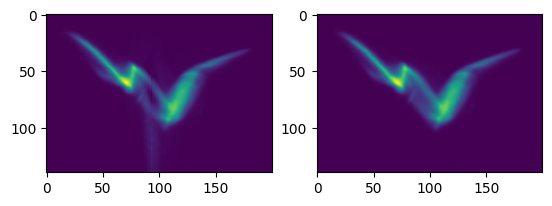

In [12]:
idx = 500
image, mask = trainset[idx]
fig, ax = plt.subplots(1,2)
ax[0].imshow(image[0])
ax[1].imshow(mask[0])

In [13]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle = False)
valloader = DataLoader(valset, batch_size= BATCH_SIZE)

## Definition of the U-Net and the training functions

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.conv0 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv7 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv10 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv11 = nn.Conv2d(32, 1, 1)
        

    def forward(self, x):
        # Encoder
        x0 = F.relu(self.conv0(x))
        
        x1 = F.relu(self.conv1(x0))
        x1 = F.relu(self.conv2(x1))
        x2 = self.pool1(x1)
        
        x2 = F.relu(self.conv3(x2))
        x2 = F.relu(self.conv4(x2))
        x3 = self.pool2(x2)
        
        # Bottleneck
        x3 = F.relu(self.conv5(x3))
        x3 = F.relu(self.conv6(x3))
        
        # Decoder
        x4 = self.upconv1(x3)
        x4 = torch.cat([x4, x2], dim=1)
        x4 = F.relu(self.conv7(x4))
        x4 = F.relu(self.conv8(x4))
        
        x5 = self.upconv2(x4)
        x5 = torch.cat([x5, x1], dim=1)
        x5 = F.relu(self.conv9(x5))
        x5 = F.relu(self.conv10(x5))
        x5 = self.conv11(x5)
        return x5

# Instantiate the model
model = UNet()

# Print the model architecture
print(model)

UNet(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv7): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv2): ConvTranspose2d(128, 64, kernel_

In [16]:
def train_function(data_loader, model, criterion, optimizer):

    model.train()
    total_loss = 0.0

    for inputs, targets in tqdm(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


def eval_function(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)

            total_loss += loss.item()

    return total_loss / len(data_loader)

## Train or Load the model

In [17]:
#model = UNet()

Train = False

if Train:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

    # Training loop
    EPOCHS = 30
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    #best_val_loss = np.Inf

    train_L, val_L = [], []
    for i in range(EPOCHS):

        train_loss = train_function(trainloader, model, criterion, optimizer)
        train_L.append(train_loss)
        val_loss = eval_function(valloader, model)
        val_L.append(val_loss)

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            best_val_loss = val_loss

        print(f"Epoch: {i+1}   Train loss: {train_loss}  Val_loss: {val_loss}")

    plt.plot(train_L, label="train loss")
    plt.plot(val_L, label="test loss")
    plt.legend()

else:
    
    model = UNet()
    state_dict = torch.load("best_model_yet.pt")
    model.load_state_dict(state_dict)
    model.to(device)
        

In [18]:
val_inp = [inputs for inputs,outputs in valloader]
val_out = [outputs for inputs,outputs in valloader]
train_inp = [inputs for inputs,outputs in trainloader]
train_out = [outputs for inputs,outputs in trainloader]

Text(0.5, 1.0, 'original image')

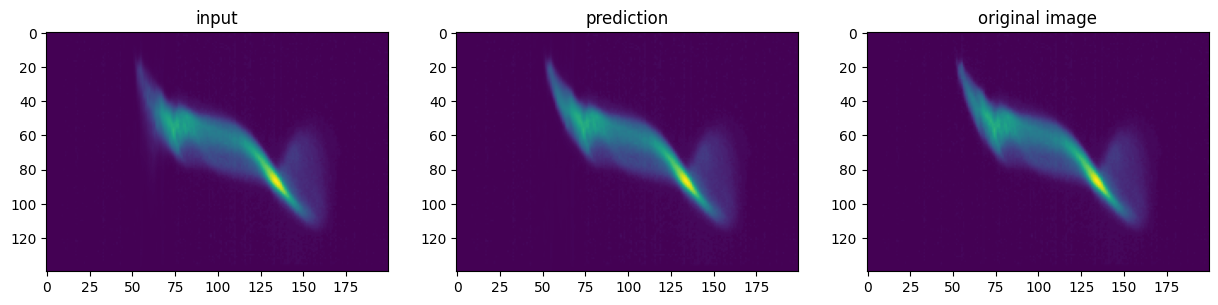

In [19]:
idx = 20
valX = val_inp[3][idx]
valX = valX.to(device)
valY = val_out[3][idx]

model.eval()
with torch.no_grad():
    val_pred = model(valX.unsqueeze(0))
    
valX = valX.squeeze().cpu()
valY = valY.squeeze().cpu()
val_pred = val_pred.squeeze().cpu()

fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0].imshow(valX)
ax[0].set_title("input")
ax[1].imshow(val_pred)
ax[1].set_title("prediction")
ax[2].imshow(valY)
ax[2].set_title("original image")

## Helper functions to predict and plot the results

In [20]:
def model_pred(model, img, plot=False):
    #device = 'cuda'
    img = (img / np.max(img)).astype(np.float32)
    kernel_size = 5
    img = cv2.medianBlur(img, kernel_size)
    M, N = (np.array(img.shape) // 5)
    img = cv2.resize(img, (N, M))
    data = get_augs()(image = img)
    img = data['image']
    
    img = np.expand_dims(img, axis=0)
    testX = torch.tensor(img).to(device)
    
    model.eval()
    with torch.no_grad():
        test_pred = model(testX.unsqueeze(0))

    testX = testX.squeeze().cpu()
    test_pred = test_pred.squeeze().cpu()
    
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].imshow(testX)
        ax[0].set_title("Input")
        ax[1].imshow(test_pred)
        ax[1].set_title("Model Prediction")
    
    return testX, test_pred


def plot_power_profile(pred_in, pred_out, dE=0.194, dT=3.876):
    
    pixel_values = np.tile(np.arange(pred_in.shape[0]), (pred_in.shape[1],1)).T
    mean_value = np.array(torch.mean(pred_in, dim=0))
    
    mean_px_sase_on  = np.ma.average(pixel_values, weights=pred_in, axis=0)
    mean_px_sase_on[mean_value < 0.005] = None
    mean_px_sase_off = np.ma.average(pixel_values, weights=pred_out, axis=0)
    mean_px_sase_off[mean_value < 0.005] = None
    mean_diff = mean_px_sase_on - mean_px_sase_off
    
    std_px_sase_on = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_on) ** 2, weights=pred_in, axis=0))
    std_px_sase_off = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_off) ** 2, weights=pred_out, axis=0))
    std_diff = std_px_sase_on**2 - std_px_sase_off**2
    
    power_px = mean_diff.copy()
    power_px[np.isnan(power_px)] = 0
    power_px = np.clip(power_px, a_min=0, a_max=None)
    power = power_px * dE
    
    T = np.linspace(0, len(power_px), len(power_px)) * dT
    E = np.linspace(0, pred_in.shape[0], pred_in.shape[0]) * dE
    E -= np.mean(E)
    
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})#, sharex=True)

    #ax[0].contourf(T, E, np.flip(np.array(pred_in), axis=0), 100)
    ax[0].imshow(pred_in, cmap='turbo', aspect='auto')
    ax[0].plot(mean_px_sase_on , alpha=0.5)
    ax[0].plot(mean_px_sase_off, alpha=0.5)
    ax[0].set_xticklabels([])  # Hide x tick labels

    ax[1].plot(T, power, label = "power profile from mean") #, alpha=0.8)
    ax[1].set_xlim(min(T), max(T))
    ax[1].set_xlabel("t (fs)")
    ax[1].set_ylabel("dE (MeV)")
    #plt.plot(140 - std_diff* 5**(2/3) * 0.15, label = "power profile from energy spread", alpha=0.7)
    #plt.legend()
    
    return np.array(power)

In [21]:
def get_energy_loss(pred_in, pred_out, dE=0.194, dT=3.876):
    
    pixel_values = np.tile(np.arange(pred_in.shape[0]), (pred_in.shape[1],1)).T
    mean_value = np.array(torch.mean(pred_in, dim=0))
    
    mean_px_sase_on  = np.ma.average(pixel_values, weights=pred_in, axis=0)
    mean_px_sase_on[mean_value < 0.005] = None
    mean_px_sase_off = np.ma.average(pixel_values, weights=pred_out, axis=0)
    mean_px_sase_off[mean_value < 0.005] = None
    mean_diff = mean_px_sase_on - mean_px_sase_off
    
    std_px_sase_on = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_on) ** 2, weights=pred_in, axis=0))
    std_px_sase_off = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_off) ** 2, weights=pred_out, axis=0))
    std_diff = std_px_sase_on**2 - std_px_sase_off**2
    
    power_px = mean_diff.copy()
    power_px[np.isnan(power_px)] = 0
    power_px = np.clip(power_px, a_min=0, a_max=None)
    power = power_px * dE
    
    return power, mean_px_sase_off, mean_px_sase_on

def get_power_profile(filestr, image_idx, dE=0.194, dT=3.876):
    
    with h5py.File(filestr,'r') as fi:
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][image_idx])
    
    pred_in, pred_out = model_pred(model, imarr[:,:])
    
    energy_loss, sase_off, sase_on = get_energy_loss(pred_in, pred_out, dE, dT)
    T = np.linspace(0, len(energy_loss), len(energy_loss)) * dT
    
    with h5py.File(filestr,'r') as fi:
        gmdarr = np.array(fi['/FL2/Photon Diagnostic/GMD/Pulse resolved energy/energy tunnel/value'])[:,0]
        bunch_charge = np.array(fi['/FL1/Electron Diagnostic/Bunch charge/at gun/value'])

    #q = sorted(bunch_charge[0])[-2] * 1e-9
    q = bunch_charge[image_idx][251] * 1e-9
    q_px = float(q / torch.sum(pred_in))

    curr_profile = (np.sum(np.array(pred_in), axis=0) * q_px)/ dT/1e-15
    power = 1e6 * energy_loss * curr_profile         
    pulse_energy = np.trapz(power, T*1e-15) * 1e6
    pulse_energy_gmd = gmdarr[image_idx][0]
    
    return power, pulse_energy, pulse_energy_gmd


In [22]:
def plot_results(filestr, image_idx, dE=0.194, dT=3.876):
    
    with h5py.File(filestr,'r') as fi:
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][image_idx])
    
    pred_in, pred_out = model_pred(model, imarr[:,:])
                                   
    energy_loss, sase_off, sase_on = get_energy_loss(pred_in, pred_out, dE, dT)
    
    T = np.linspace(0, len(energy_loss), len(energy_loss)) * dT
    
    power, E, E_gmd = get_power_profile(filestr, image_idx)
    #print(E, E_gmd)
    
    fig = plt.figure(figsize=(15,8))
    gs_main = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    ax1 = fig.add_subplot(gs_main[0, 0])
    ax1.imshow(pred_in, aspect='auto')
    ax1.set_title('Input SASE-ON')

    ax2 = fig.add_subplot(gs_main[0, 1])
    ax2.imshow(pred_out, aspect='auto')
    ax2.set_title('Predicted SASE-OFF')
    
    gs_lower_left = gs_main[1, 0].subgridspec(2, 1, height_ratios=[4, 1])
    
    ax3 = fig.add_subplot(gs_lower_left[0])
    ax3.imshow(pred_in, cmap='turbo', aspect='auto')
    ax3.plot(sase_on , 'red', alpha=0.8)
    ax3.plot(sase_off, 'orange', alpha=0.8)
    ax3.set_xticklabels([])
    
    ax4 = fig.add_subplot(gs_lower_left[1])
    ax4.plot(T, energy_loss, label = "power profile from mean") #, alpha=0.8)
    ax4.set_xlim(min(T), max(T))
    ax4.set_xlabel("t (fs)")
    ax4.set_ylabel("dE (MeV)")
    
    ax5 = fig.add_subplot(gs_main[1, 1])
    ax5.plot(T, power/1e9, 'r')
    ax5.set_xlim(min(T), max(T))
    ax5.set_xlabel("t (fs)")
    ax5.set_ylabel("power (GW)")

    pulse_energy_text = f"Integrated Power: {E:.2f}" + " $\mu$J \n" + f"Pulse Energy from GMD: {E_gmd:.2f} " + " $\mu$J"

    ax = plt.gca()
    ax.text(0.95, 0.95, pulse_energy_text , transform=ax.transAxes, ha='right', va='top')
    
    plt.suptitle(f"{os.path.basename(filestr)}   index: {image_idx}")
    

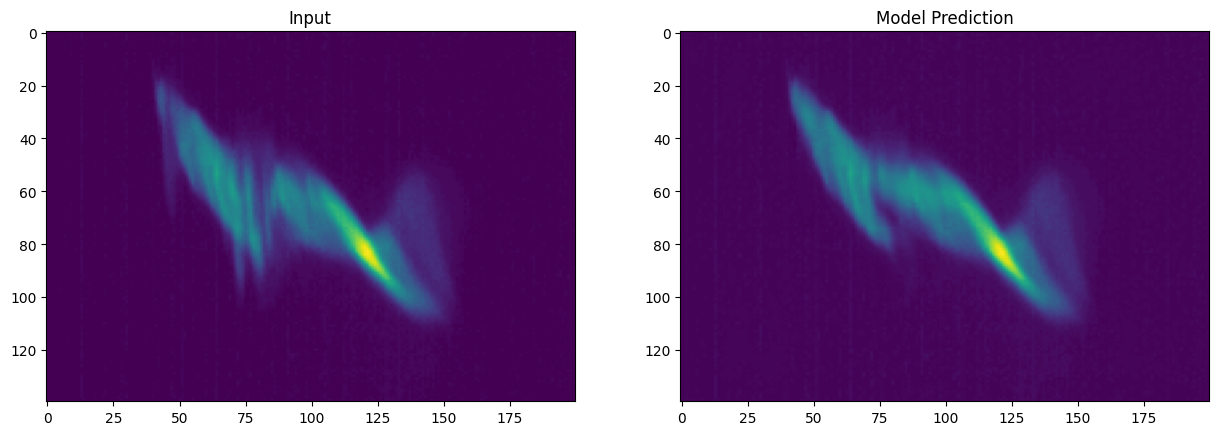

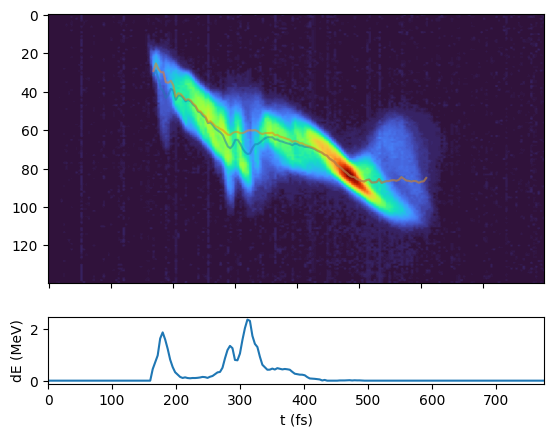

In [23]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50626}*20240125*')[0]

with h5py.File(filestr,'r') as fi:
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][1])

dE = 776 * 0.035 / 140  # MeV/pixel
dT = 1360 * 0.57 / 200  # fs/pixel

pred_in, pred_out = model_pred(model, imarr[:,:], plot=True)
power_px = plot_power_profile(pred_in, pred_out, dE, dT)

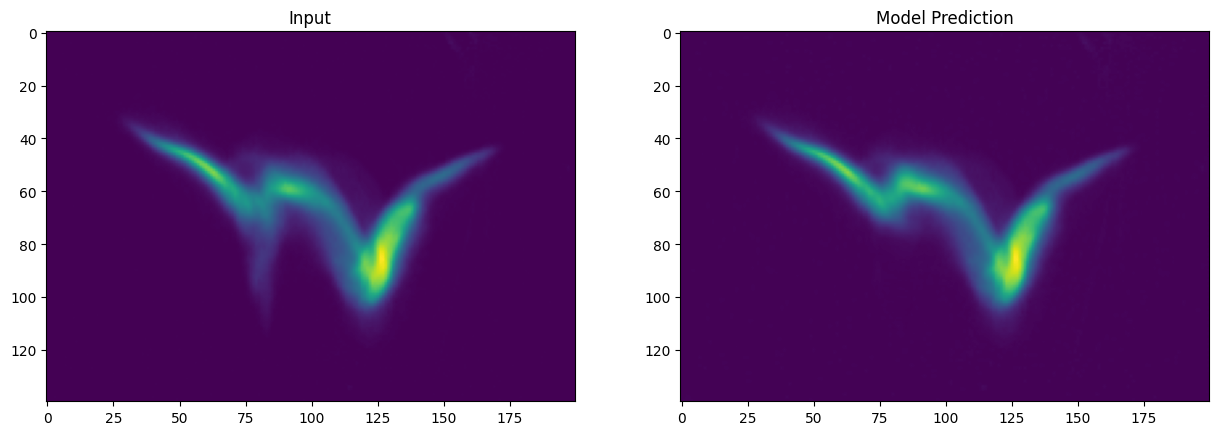

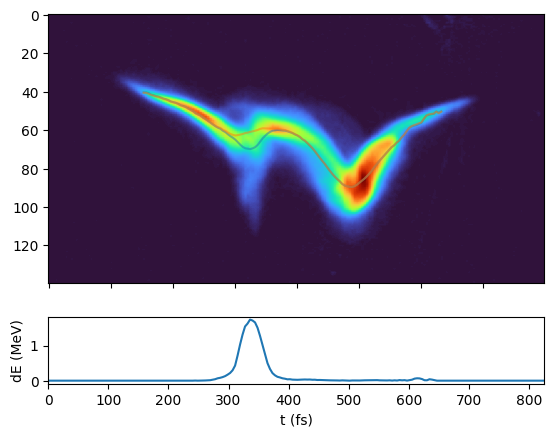

In [23]:
# sase_on = np.load("data/lhpulses_zero-sase_on-polarix-2023-11-08T032511.npy").astype(np.float32)
sase_on = np.load("data/lhpulses_two-sase_on-polarix-2023-11-08T031510.npy").astype(np.float32)
img = sase_on[6]

dE = 706 * 0.0384 / 140  # MeV/pixel
dT = 1100 * 0.75 / 200  # fs/pixel

pred_in, pred_out = model_pred(model, img, plot=True)
power = plot_power_profile(pred_in, pred_out, dE, dT)

# Estimate the power profile and pulse energy

In [29]:
## This is the unsuitable staset for the model
filepath = '/asap3/flash/gpfs/fl21/2023/data/11019168/raw/hdf/online-0/fl2user2/'
filestr = glob.glob(filepath+f'/*run{49479}*20231121*')[0]

dE = 444 * 0.030 / 140  # MeV/pixel
dT = 1356 * 0.61 / 200  # fs/pixel

In [173]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50626}*20240125*')[0]

dE = 776 * 0.035 / 140  # MeV/pixel
dT = 1360 * 0.57 / 200  # fs/pixel

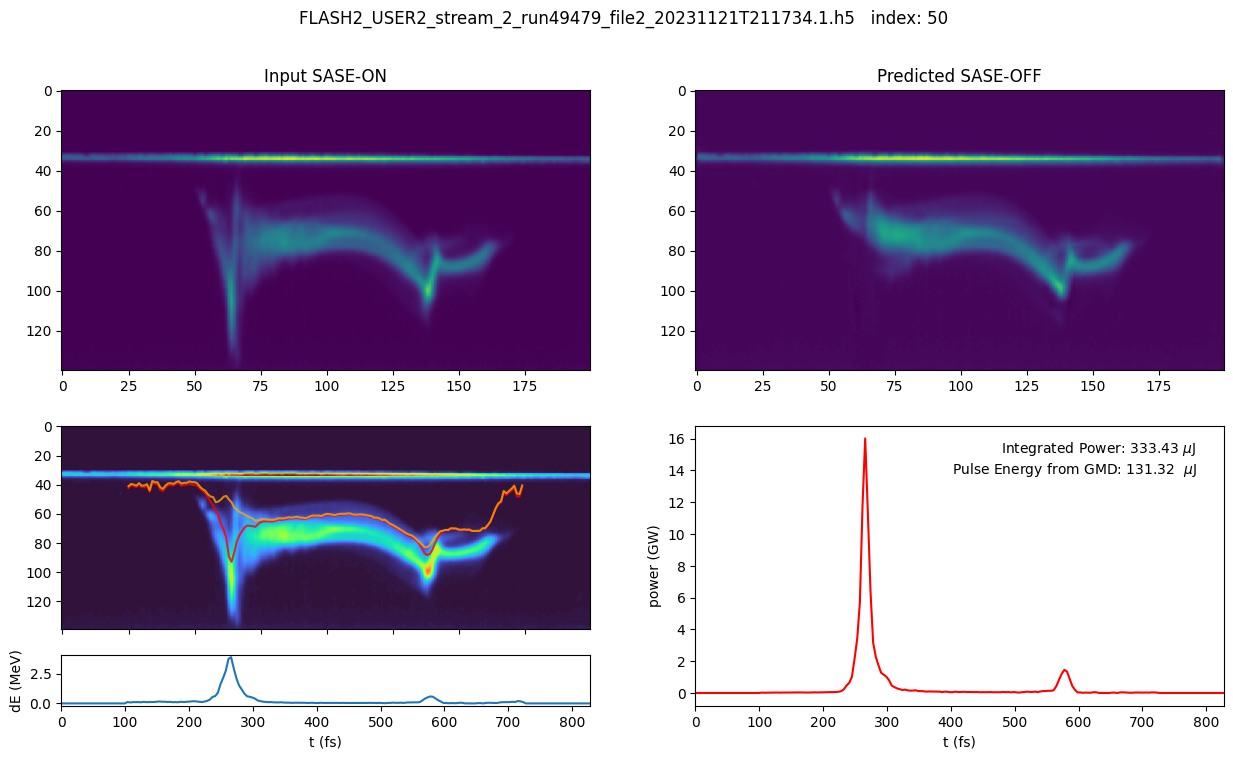

In [31]:

image_idx = 50

plot_results(filestr, image_idx, dE, dT)

In [174]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50626}*20240125*')[0]

dE = 776 * 0.035 / 140  # MeV/pixel
dT = 1360 * 0.57 / 200  # fs/pixel

for image_idx in range(0, 100, 10):
    plot_results(filestr, image_idx, dE, dT)
   # plt.savefig(f"results/{os.path.basename(filestr)}_index: {image_idx}.png")
    plt.close()
    

In [27]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50630}*20240125*')[0]

with h5py.File(filestr,'r') as fi:
    imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'])

imarr.shape[0]

1038

In [35]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50626}*20240125*')[0]

with h5py.File(filestr,'r') as fi:
    imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'])
img_len = imarr.shape[0]

dE = 776 * 0.035 / 140  # MeV/pixel
dT = 1360 * 0.57 / 200  # fs/pixel

E0_list = []
Egmd_list = []
for image_idx in tqdm(range(img_len)):
    _, E0, E_gmd = get_power_profile(filestr, image_idx, dE, dT)
    E0_list.append(E0)
    Egmd_list.append(E_gmd)

100%|██████████| 1145/1145 [01:00<00:00, 19.07it/s]


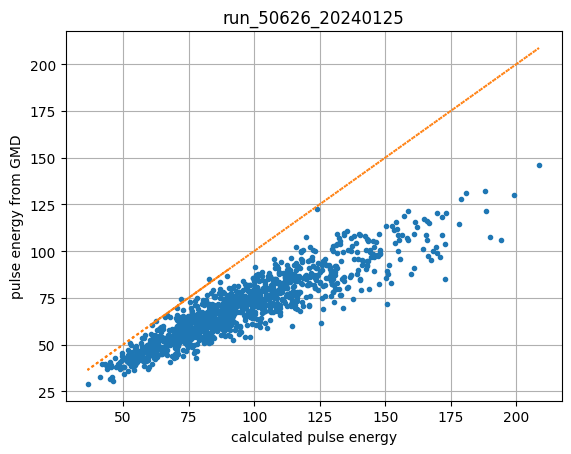

In [36]:
plt.plot(E0_list, Egmd_list, '.')
plt.xlabel("calculated pulse energy")
plt.ylabel("pulse energy from GMD")
plt.plot(E0_list, E0_list, ':')
plt.title("run_50626_20240125")
plt.grid()

In [ ]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50630}*20240125*')[0]

with h5py.File(filestr,'r') as fi:
    imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'])
img_len = imarr.shape[0]

dE = 776 * 0.035 / 140  # MeV/pixel
dT = 1360 * 0.57 / 200  # fs/pixel

E0_list = []
Egmd_list = []
for image_idx in tqdm(range(img_len)):
    _, E0, E_gmd = get_power_profile(filestr, image_idx, dE, dT)
    E0_list.append(E0)
    Egmd_list.append(E_gmd)

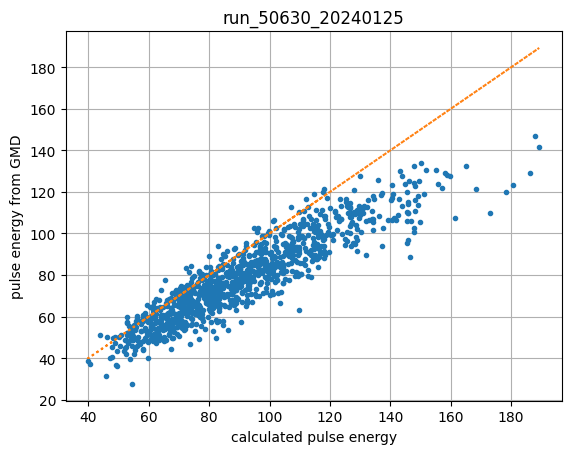

In [34]:
plt.plot(E0_list, Egmd_list, '.')
plt.xlabel("calculated pulse energy")
plt.ylabel("pulse energy from GMD")
plt.plot(E0_list, E0_list, ':')
plt.title("run_50630_20240125")
plt.grid()

In [145]:
with h5py.File(filestr,'r') as fi:
    gmdarr_in = np.array(fi['/FL2/Photon Diagnostic/GMD/Pulse resolved energy/energy tunnel/index'])
    gmdarr = np.array(fi['/FL2/Photon Diagnostic/GMD/Pulse resolved energy/energy tunnel/value'])[:,0]
    bunch_charge = np.array(fi['/FL1/Electron Diagnostic/Bunch charge/at gun/value'])

#q = sorted(bunch_charge[0])[-2] * 1e-9
q = bunch_charge[image_idx][251] * 1e-9
q_px = float(q / torch.sum(pred_in))
T = np.linspace(0, len(power_px), len(power_px)) * dT

pulse_energy_gmd = gmdarr[image_idx]

Pulse energy: 
From GMD: 71.86418151855469 muJ 
From UNet: 97.52269206119104 muJ


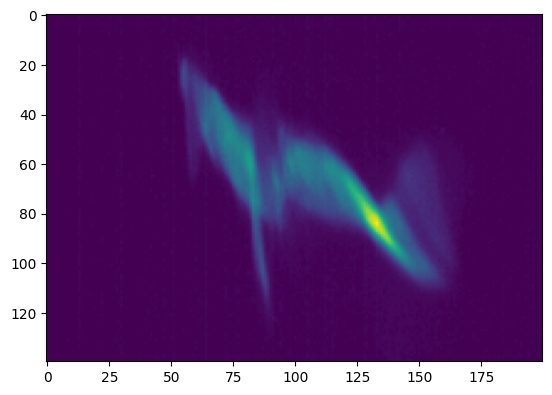

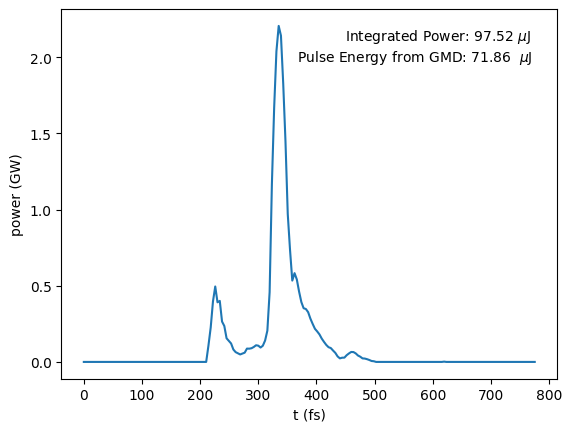

In [146]:
plt.imshow(pred_in)
plt.figure()
curr_profile = (np.sum(np.array(pred_in), axis=0) * q_px)/ dT/1e-15

power_px[np.isnan(power_px)] = 0
power_px = np.clip(power_px, a_min=0, a_max=None)
power = 1e6 * power_px * dE * curr_profile         

plt.plot(T, power/1e9)
plt.xlabel("t (fs)")
plt.ylabel("power (GW)")

pulse_energy = np.trapz(power, T*1e-15) * 1e6

pulseenergy_text = f"Integrated Power: {pulse_energy:.2f}" + " $\mu$J \n" + f"Pulse Energy from GMD: {pulse_energy_gmd[0]:.2f} " + " $\mu$J"

ax = plt.gca()
ax.text(0.95, 0.95, pulseenergy_text , transform=ax.transAxes, ha='right', va='top')

print(f"Pulse energy: \nFrom GMD: {pulse_energy_gmd[0]} muJ \nFrom UNet: {pulse_energy} muJ")

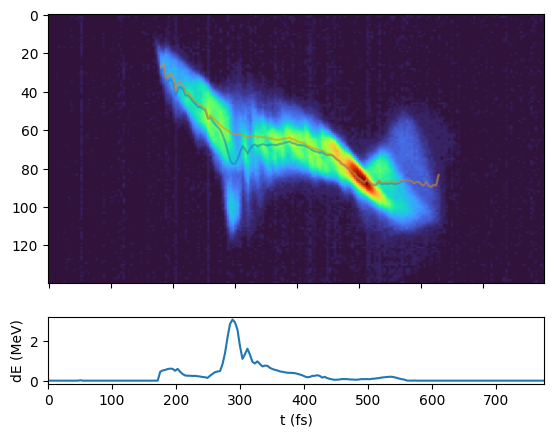

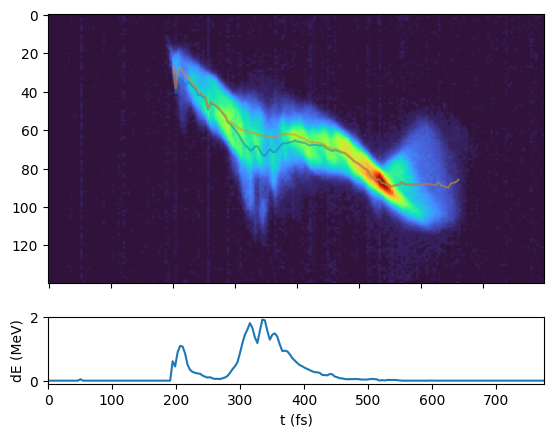

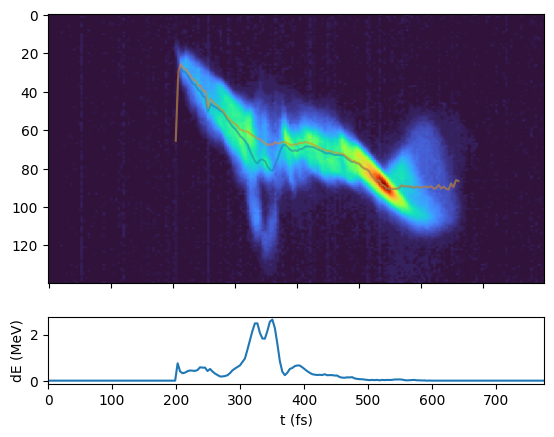

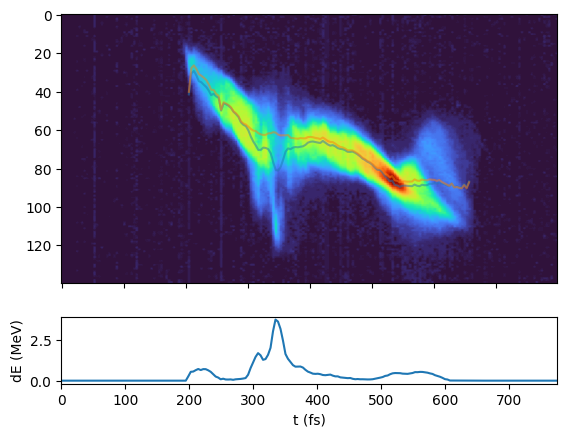

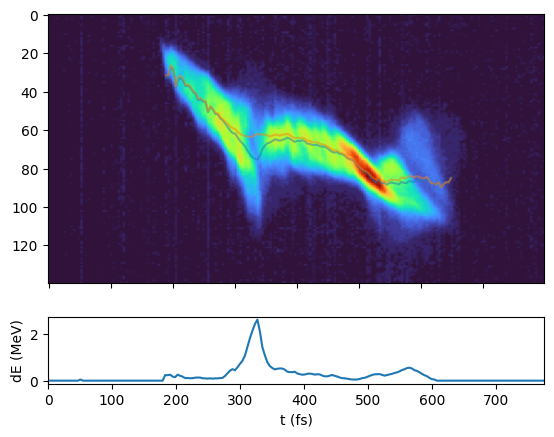

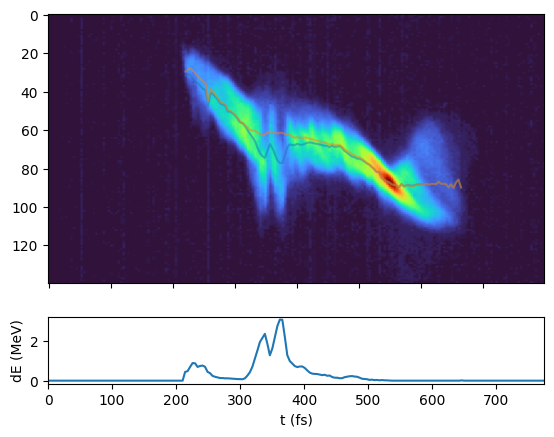

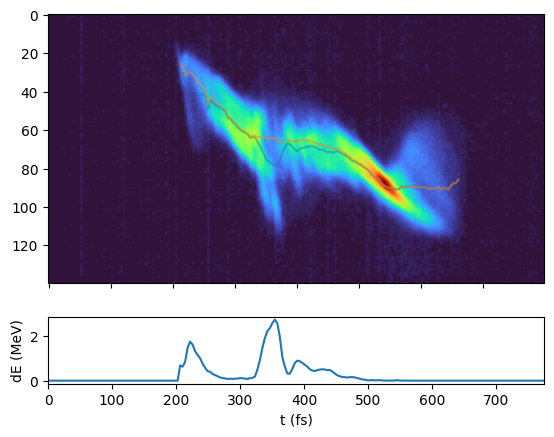

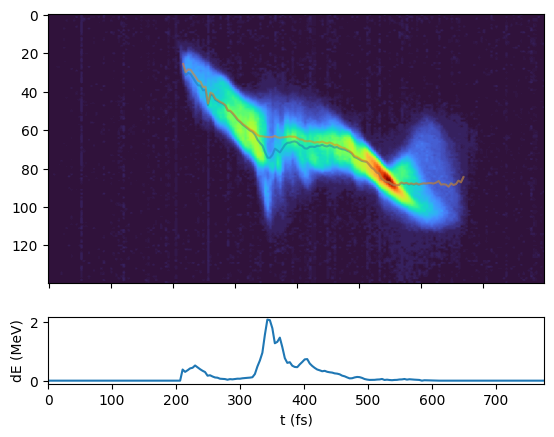

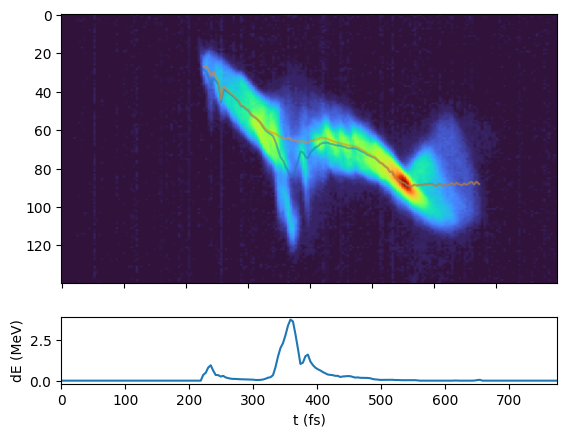

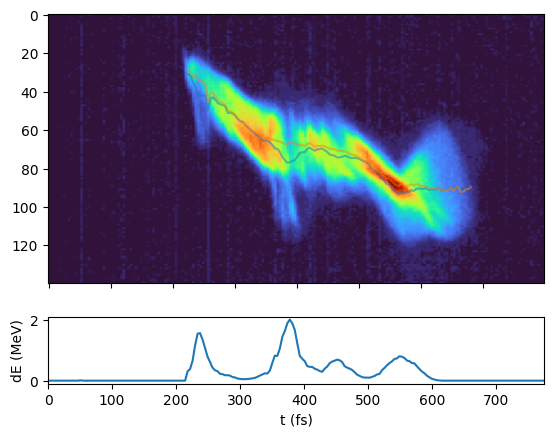

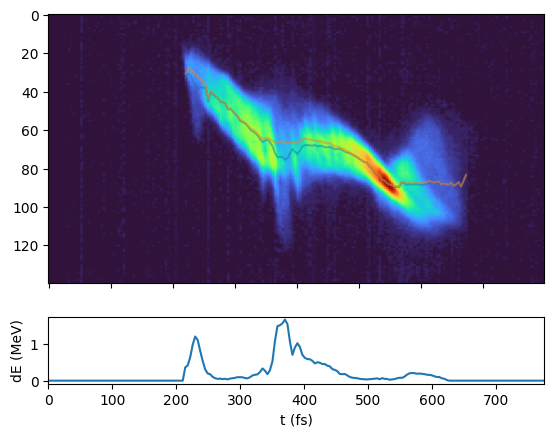

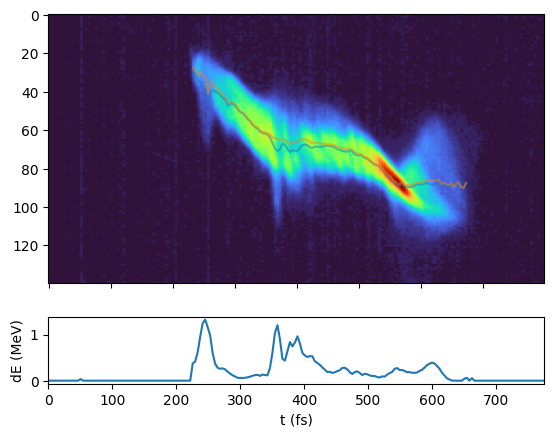

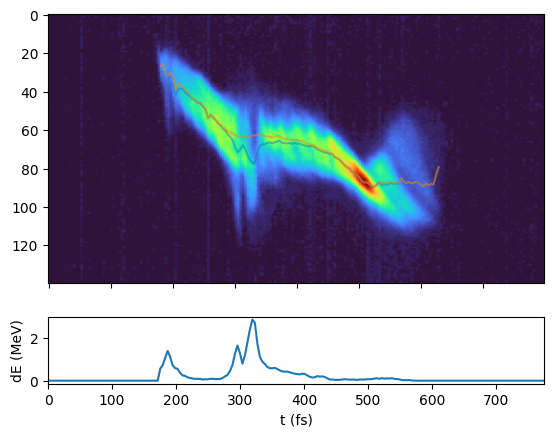

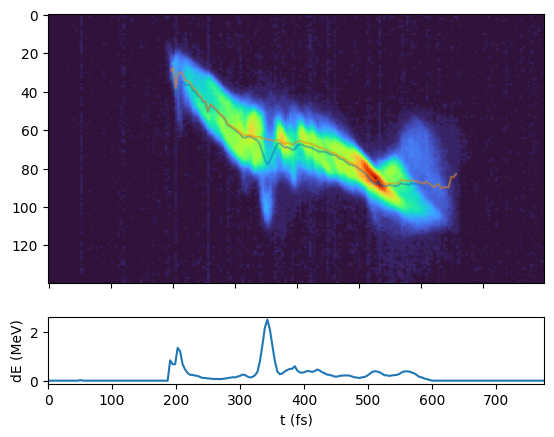

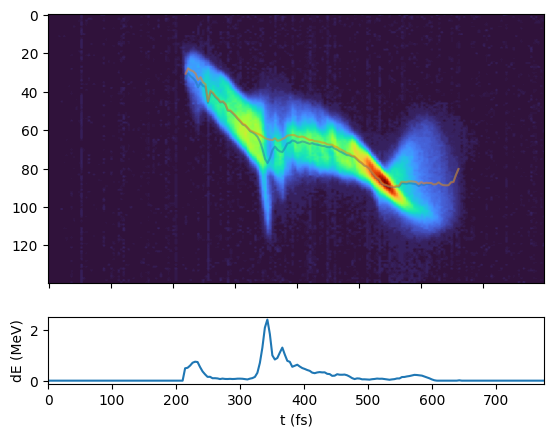

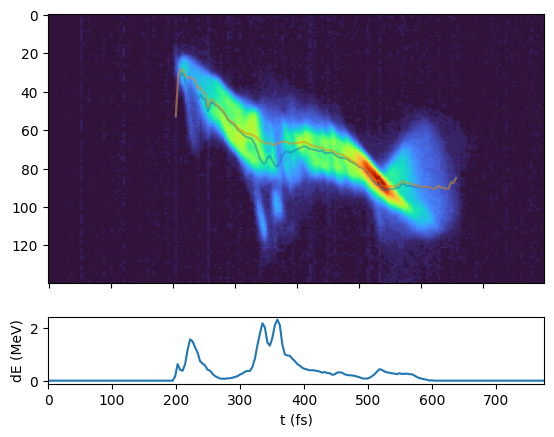

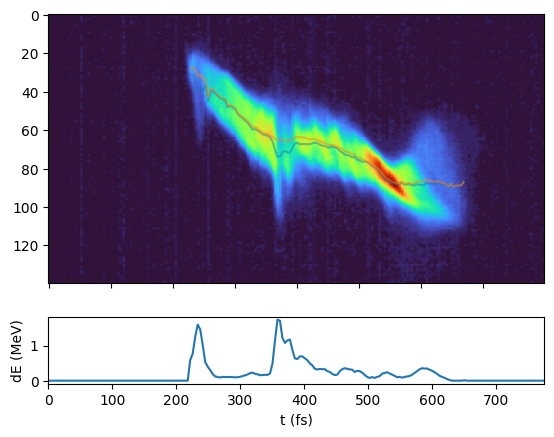

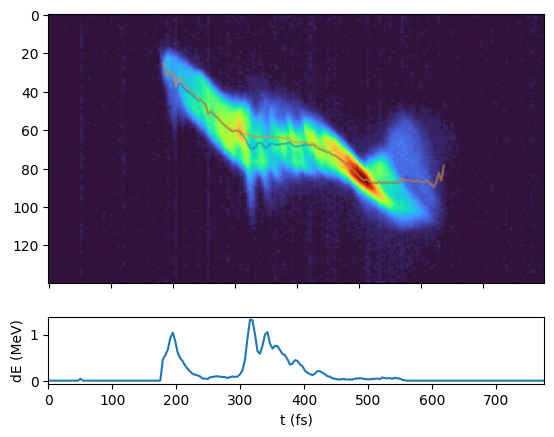

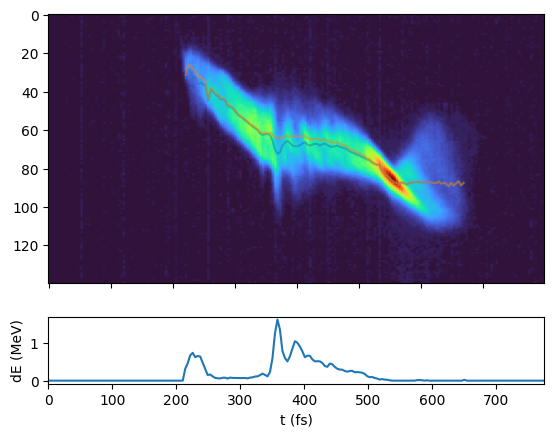

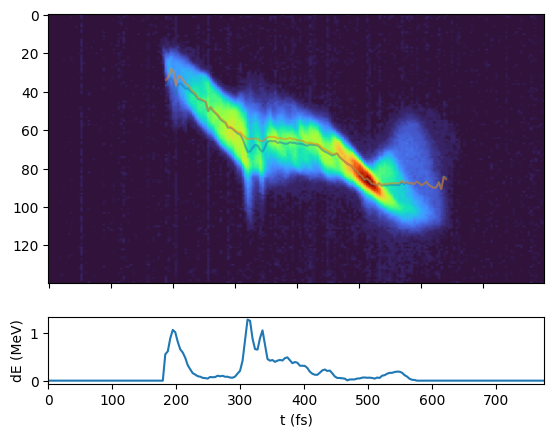

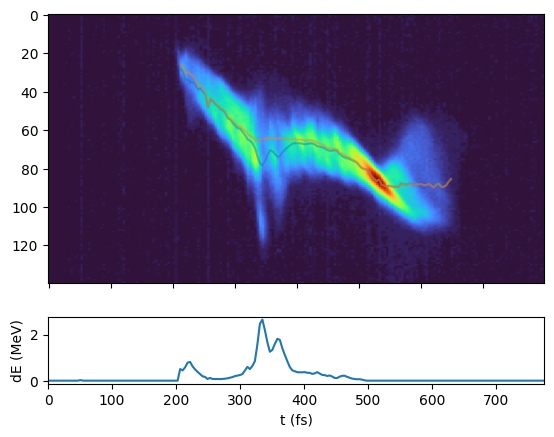

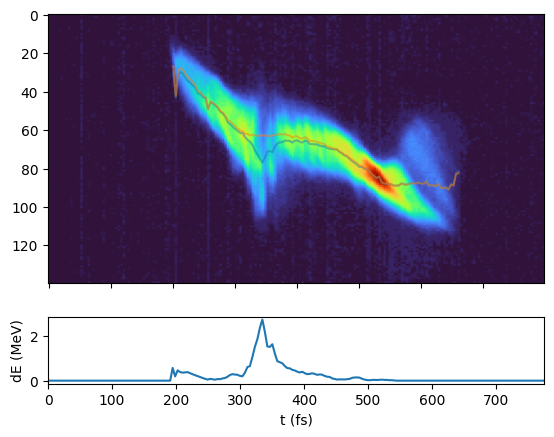

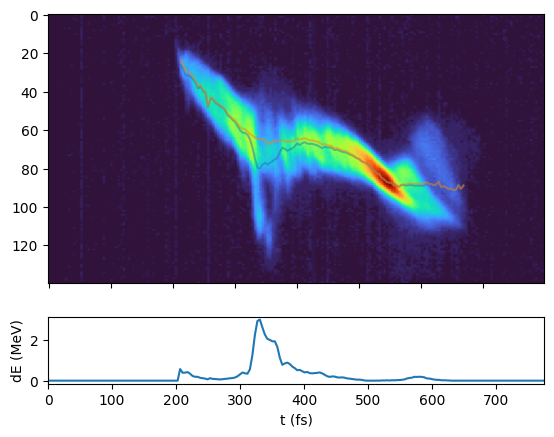

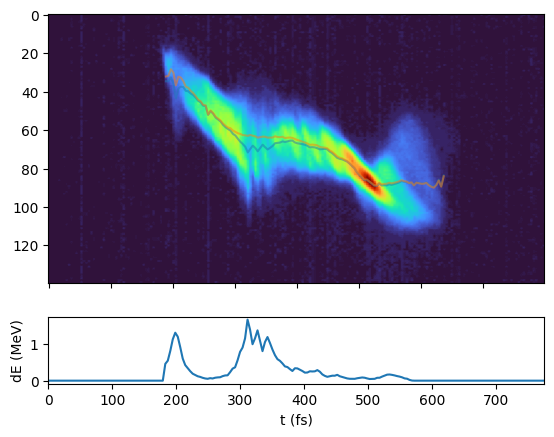

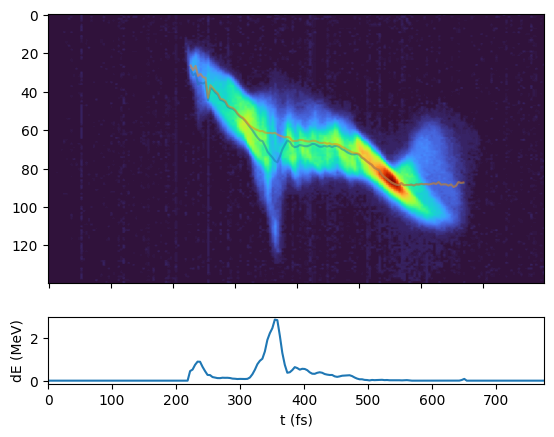

In [138]:
with h5py.File(filestr,'r') as fi:
    for i in range(25):
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][i])
        pred_in, pred_out = model_pred(model, imarr[:,:], plot=False)
        power = plot_power_profile(pred_in, pred_out)


In [46]:
torch.sum(pred_in)

tensor(1175.1168)

# Playground

In [53]:
dE = 776 * 0.035 / 140  # MeV/pixel
dT = 1360 * 0.57 / 200  # fs/pixel

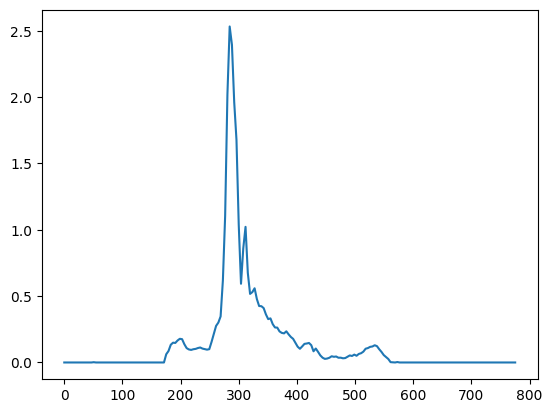

In [114]:
power_px[np.isnan(power_px)] = 0
power_px = np.clip(power_px, a_min=0, a_max=None)
T = np.linspace(0, len(power_px), len(power_px)) * dT
power = 1e6 * power_px * dE * curr_profile
plt.plot(T, power/1e9)

In [115]:
np.trapz(power, T*1e-15)

0.00011719846679229239

0.000435583

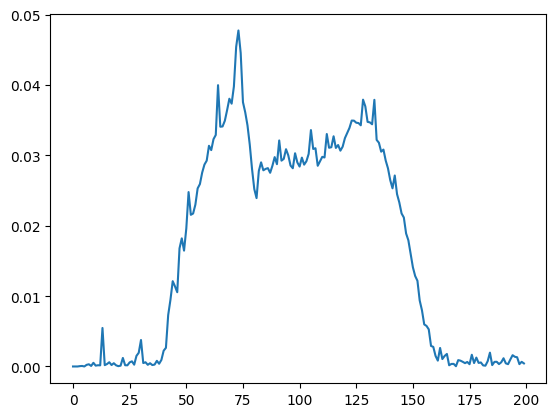

In [116]:
mean_i = np.array(torch.mean(pred_in, dim=0))
plt.plot(mean_i)
np.mean(mean_i[:25])

In [ ]:
for i in range(2000, 3000, 20):
    idx = i
    plt.figure()
    plt.imshow(train_data2["train_X"][i])
    plt.title(f"{idx}")

In [142]:
with h5py.File(filestr,'r') as fi:
    for i in range(10):
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][i])
        pred_in, pred_out = model_pred(model, imarr[:,:], plot=True)
        plt.savefig(f"images/run_50630_20240125_example{i}.png")
        plt.close()

In [143]:
with h5py.File(filestr,'r') as fi:
    for i in range(10):
        imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][i])
        pred_in, pred_out = model_pred(model, imarr[:,:], plot=False)
        power = plot_power_profile(pred_in, pred_out)
        plt.savefig(f"images/run_50630_20240125_profile_{i}.png")
        plt.close()

In [ ]:
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols)#, figsize=(1000, 100))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')  # Adjust cmap as needed
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [32]:
## This is the unsuitable staset for the model
filepath = '/asap3/flash/gpfs/fl21/2023/data/11019168/raw/hdf/online-0/fl2user2/'
filestr = glob.glob(filepath+f'/*run{49479}*20231121*')[0]

dE = 444 * 0.030 / 140  # MeV/pixel
dT = 1356 * 0.61 / 200  # fs/pixel

with h5py.File(filestr,'r') as fi:
    imarr = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'])
img_len = imarr.shape[0]

E0_list = []
Egmd_list = []
for image_idx in tqdm(range(img_len)):
    _, E0, E_gmd = get_power_profile(filestr, image_idx, dE, dT)
    E0_list.append(E0)
    Egmd_list.append(E_gmd)

100%|██████████| 1026/1026 [00:43<00:00, 23.72it/s]


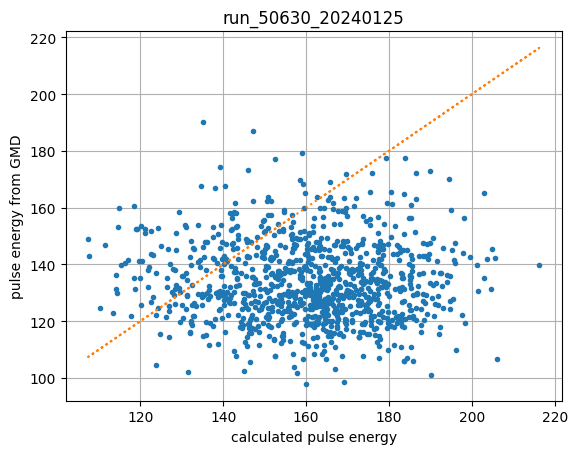

In [33]:
plt.plot(E0_list, Egmd_list, '.')
plt.xlabel("calculated pulse energy")
plt.ylabel("pulse energy from GMD")
plt.plot(E0_list, E0_list, ':')
plt.title("run_50630_20240125")
plt.grid()